# Init

In [19]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [20]:
dg = DataGenerator(natoms=5, nclusters=2, natoms_per_cluster=[1, 1], nframes_per_cluster=1000, 
                   noise_level=0, #1e-2, 
                   displacement=0.1, 
                   noise_natoms=None,
                   feature_type='carteesian',
                   test_model='linear')
#dg.generate_frames()
#dg.generate_clusters()
dg.select_atoms_to_move()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = dg.feature_to_resids()
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2019-01-18 11:49:25 dataGen-INFO: Selecting atoms to be moved ...
2019-01-18 11:49:25 dataGen-INFO: Generating frames ...
2019-01-18 11:49:25 dataGenNb-INFO: Generated data of shape (2000, 15) and 2 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [21]:
n_iterations, n_splits = 4,2 
filter_by_distance_cutoff = False 
feature_extractors = [
    fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(3, 2), training_max_iter=10000, 
                           activation="logistic", 
                          filter_by_distance_cutoff=filter_by_distance_cutoff), #, solver="sgd"),
    #fe.RbmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, n_components=8, 
    #                       filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                           activation="logistic",
                           n_nodes=3*dg.nfeatures, 
                           alpha=1.,
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits, 
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    #fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_components=None,
    #                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    #fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
    #                                                           filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-01-18 11:49:25 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 2, n_iterations 4, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (3, 2), solver lbfgs, activation function logistic, randomize True, training_max_iter 10000
2019-01-18 11:49:25 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 2, n_iterations 4, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (100,), solver lbfgs, activation function logistic, randomize True, training_max_iter 100000
2019-01-18 11:49:25 elm-DEBUG: Initializing ELM with the following parameters:                       n_splits 2, n_iterations 4, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_nodes 45, activation function logistic, alpha 1.0
2019-01-18 11:49:25 KL divergence-DEBUG: Initializing KL with the follo

In [22]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 500
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-01-18 11:49:25 dataGenNb-INFO: Computing relevance for extractors MLP
2019-01-18 11:49:25 Extracting features-INFO: Performing feature extraction with MLP on data of shape (2000, 15)
2019-01-18 11:49:25 mlp-DEBUG: Training MLP with 1000 samples and 15 features ...
2019-01-18 11:49:25 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-18 11:49:25 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-18 11:49:26 mlp-DEBUG: Training MLP with 1000 samples and 15 features ...
2019-01-18 11:49:26 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-18 11:49:26 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-18 11:49:26 mlp-DEBUG: Training MLP with 1000 samples and 15 features ...
2019-01-18 11:49:27 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-18 11:49:27 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min

# Postprocess results to get average features

In [23]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids, 
                                     filter_results=False,
                                     #filter_results_by_cutoff=False,
                                     predefined_relevant_residues=dg.moved_atoms)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 utils-INFO: Rescaling feature importances ...
2019-01-18 11:49:36 dataGenNb-INFO: Done


# Evaluate results

## Find top ranked residues

2019-01-18 11:49:36 dataGenNb-INFO: Actual atoms moved: [[0], [1]].
(Cluster generation method linear. Noise level=0, displacement=0.1. frames/cluster=1000)
2019-01-18 11:49:36 dataGenNb-INFO: Moved atoms for MLP: [2, 4]
2019-01-18 11:49:36 dataGenNb-INFO: Moved atoms for ELM: [1, 3]
2019-01-18 11:49:36 dataGenNb-INFO: Moved atoms for KL: [0, 2]


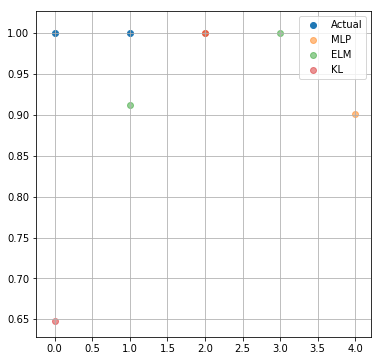

In [24]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.test_model, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
def show_moved_atoms(dg, postprocessors):
    plt.figure(figsize=(6,6))
    yvalues = np.zeros(len(dg.moved_atoms)) + 1
    plt.scatter(dg.moved_atoms, yvalues, label="Actual")
    for pp in postprocessors:
        #Get most relevant atoms, not that they are not sorted
        label=pp.extractor.name
        moved_atoms = np.argpartition(pp.importance_per_residue, -dg.nclusters)[-dg.nclusters:]
        importance_moved_atoms = pp.importance_per_residue[moved_atoms]
        plt.scatter(moved_atoms, importance_moved_atoms, label=label, alpha=0.5)
        logger.info("Moved atoms for %s: %s", label, sorted(moved_atoms) )
    plt.legend()
    plt.grid()
    plt.show()
    
show_moved_atoms(dg, postprocessors)    

## Visualize them

In [25]:
data_projectors = []
for p in postprocessors:
    #p.filter_feature_importance_by_rank(filter_by_rank_cutoff=filter_by_rank_cutoff)
    #p.average().persist()
    projector = dp.DataProjector(p, data)
    projector.project().score_projection()
    data_projectors.append([projector])
visualization.visualize([[p] for p in postprocessors], data_projectors)
logger.info("Done")

2019-01-18 11:49:36 projection-INFO: Scoring raw projections.


IndexError: too many indices for array